reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#10removestopwordsmakebigramsandlemmatize

In [6]:
import nltk
nltk.download('stopwords') # run this only once
!python3 -m spacy download en # run this only once

     |████████████████████████████████| 12.0 MB 653 kB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=1af9acf773f724d33f1a48a66385f1c9a9dcae16d040a2b95c2cbec9adfa16da
  Stored in directory: /private/var/folders/wc/svbbf96j1d75znyyg8vnm5c80000gn/T/pip-ephem-wheel-cache-c30em6ww/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/chengchen/opt/anaconda3/envs/cc_nlp/lib/python3.8/site-packages/en_core_web_sm
-->
/Users/chengchen/opt/anaconda3/envs/cc_nlp/lib/python3.8/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [15]:
# spacy for lemmatization
import spacy

In [22]:
import re
import numpy as np
import pandas as pd

from pprint import pprint

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import json
import pickle

In [21]:
# NLTK stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

### import data

In [25]:
with open("../src/config.json") as f:
    config = json.load(f)
with open(config['data_path']+'processed/'+'review_pros_subset.pkl', 'rb') as f:
    df = pickle.load(f)

In [26]:
df.head()

,review_pros,review_date,company_name,review_year
98560,"Great team, flexibility, learning, high techno...",10/17/2016,Hewlett-Packard,2016.0
17253,Great company to work for,04/13/2016,Lowe's,2016.0
80327,very Flexible schedule with good benefits,10/18/2016,J.P. Morgan,2016.0
26974,Great company and atmosphere. Starbucks offers...,09/16/2016,Starbucks,2016.0
77991,If you don't have any development experience t...,04/01/2016,Amazon.com,2016.0


In [27]:
data = df.review_pros.values.tolist()

### tokenize words and clean-up text

In [29]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

In [30]:
data_words = list(sent_to_words(data))

In [31]:
print(data[:1])

['Great team, flexibility, learning, high technology.']


In [32]:
print(data_words[:1])

[['great', 'team', 'flexibility', 'learning', 'high', 'technology']]


### create bigram and trigram models

In [41]:
# build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)

In [42]:
# faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [43]:
# see trigram example
print(trigram_mod[bigram_mod[data_words[3]]])  # stock_options

['great', 'company', 'and', 'atmosphere', 'starbucks', 'offers', 'matched', 'and', 'vested', 'stock_options']


### remove stopwords, make bigrams and lemmatize

In [44]:
# define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [47]:
# call the functions in order
# remove stopwords
data_words_nostops = remove_stopwords(data_words)

In [48]:
# form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [49]:
# initialize spacy 'en' model, keeping only tagger component (for efficienty)
nlp = spacy.load('en', disable=['parser', 'ner'])

In [58]:
# do lemmatization keeping only noun, adj, vb, adv, propn
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN'])
print(data_lemmatized[3])

['great', 'company', 'atmosphere', 'starbucks', 'offer', 'match', 'vest', 'stock_options']


### create the dictionary and corpus needed for topic modeling

In [60]:
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [61]:
# create corpus
texts = data_lemmatized
# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [63]:
# view
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [65]:
print(id2word[0])

flexibility


In [66]:
# human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('flexibility', 1),
  ('great', 1),
  ('high', 1),
  ('learn', 1),
  ('team', 1),
  ('technology', 1)]]

### build the topic model

In [67]:
# build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### view topics in the LDA model

In [68]:
# print keywords in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.316*"opportunity" + 0.152*"fun" + 0.132*"care" + 0.132*"training" + '
  '0.071*"offer" + 0.051*"advancement" + 0.041*"bonus" + 0.019*"fast_pace" + '
  '0.014*"bring" + 0.013*"dedicated"'),
 (1,
  '0.374*"environment" + 0.204*"get" + 0.081*"want" + 0.080*"awesome" + '
  '0.046*"week" + 0.045*"come" + 0.043*"available" + 0.025*"amount" + '
  '0.019*"understand" + 0.012*"relatively"'),
 (2,
  '0.696*"great" + 0.074*"culture" + 0.035*"product" + 0.032*"customer" + '
  '0.032*"leadership" + 0.032*"wonderful" + 0.032*"change" + '
  '0.021*"supervisor" + 0.015*"leader" + 0.008*"reason"'),
 (3,
  '0.540*"people" + 0.108*"love" + 0.090*"always" + 0.069*"growth" + '
  '0.037*"see" + 0.025*"plenty" + 0.022*"ever" + 0.021*"especially" + '
  '0.020*"smart" + 0.016*"policy"'),
 (4,
  '0.388*"employee" + 0.306*"place" + 0.137*"atmosphere" + 0.031*"leave" + '
  '0.022*"match" + 0.019*"responsibility" + 0.014*"hr" + 0.013*"connection" + '
  '0.009*"coverage" + 0.006*"politic"'),
 (5,
  '0.180

### compute coherence score (a measure to judge how good a given topic model is)

In [69]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence score: {coherence_lda}")

Coherence score: 0.48784250958634107


### build LDA Mallet model (to be compared to the Gensim version)

In [71]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/chengchen/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [73]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

[(6,
  [('environment', 0.2464512891012842),
   ('friendly', 0.13005575376692524),
   ('working', 0.07111605730308883),
   ('atmosphere', 0.06044537549234613),
   ('staff', 0.056866660120236105),
   ('fun', 0.03931131550522078),
   ('helpful', 0.03790383293509214),
   ('colleague', 0.03267759920569976),
   ('supportive', 0.030157223440585686),
   ('co_workers', 0.027309526147534725)]),
 (4,
  [('time', 0.15484076367707017),
   ('day', 0.07556664715366998),
   ('year', 0.053732630865452755),
   ('pro', 0.03300777438867836),
   ('part', 0.030286224851341775),
   ('long', 0.02934138501196455),
   ('full', 0.02801655523718561),
   ('week', 0.02592147559334915),
   ('start', 0.021875096281233634),
   ('leave', 0.020160006572798882)]),
 (16,
  [('project', 0.062481103454027964),
   ('technology', 0.041014627229792426),
   ('client', 0.04073313385531241),
   ('interesting', 0.03509284068517572),
   ('industry', 0.027440391171533723),
   ('travel', 0.025198869856229867),
   ('exposure', 0.0243

In [75]:
# compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.601926948255689


Mallet's coherence score is much higher than Gensim version!!

### find optimal number of topics for LDA

In [78]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics
    
    Parameters:
    ----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: List of input texts
    limit: Max num of topics
    
    Returns:
    -------
    model_list: List of LDA topic models
    coherence_values: Coherence values corresponding to the LDA model with respective to number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"modelling for num topics: {num_topics} ... ")
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [79]:
# compute coherence scores for different # topics (this could take long)
limit = 30
start = 2
step = 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

modelling for num topics: 2 ... 
modelling for num topics: 4 ... 
modelling for num topics: 6 ... 
modelling for num topics: 8 ... 
modelling for num topics: 10 ... 
modelling for num topics: 12 ... 
modelling for num topics: 14 ... 
modelling for num topics: 16 ... 
modelling for num topics: 18 ... 
modelling for num topics: 20 ... 
modelling for num topics: 22 ... 
modelling for num topics: 24 ... 
modelling for num topics: 26 ... 
modelling for num topics: 28 ... 


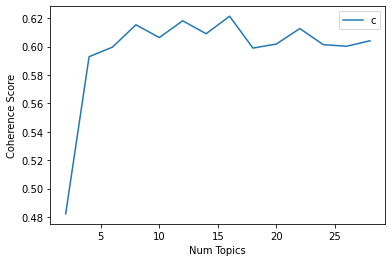

In [81]:
# show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [82]:
# print the coherence scores
for m, cv in zip(x, coherence_values):
    print(f"Num topics: {m} has coherence value of {round(cv,4)}")

Num topics: 2 has coherence value of 0.4822
Num topics: 4 has coherence value of 0.5929
Num topics: 6 has coherence value of 0.5996
Num topics: 8 has coherence value of 0.6153
Num topics: 10 has coherence value of 0.6064
Num topics: 12 has coherence value of 0.6182
Num topics: 14 has coherence value of 0.609
Num topics: 16 has coherence value of 0.6214
Num topics: 18 has coherence value of 0.599
Num topics: 20 has coherence value of 0.6018
Num topics: 22 has coherence value of 0.6127
Num topics: 24 has coherence value of 0.6014
Num topics: 26 has coherence value of 0.6002
Num topics: 28 has coherence value of 0.6041


#### It seems that having 8 topics brings most marginal increase in coherence score, whereas keeping the topic model simple. (i.e. pick the model that gave the highest CV before flattening out.)

In [84]:
# select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.131*"benefit" + 0.102*"pay" + 0.059*"flexible" + 0.056*"hour" + '
  '0.055*"time" + 0.033*"schedule" + 0.029*"decent" + 0.028*"salary" + '
  '0.018*"job" + 0.015*"offer"'),
 (1,
  '0.061*"company" + 0.021*"product" + 0.019*"business" + 0.016*"client" + '
  '0.014*"high" + 0.014*"leadership" + 0.013*"strong" + 0.013*"industry" + '
  '0.012*"organization" + 0.012*"team"'),
 (2,
  '0.303*"great" + 0.168*"people" + 0.130*"work" + 0.060*"nice" + '
  '0.050*"place" + 0.038*"company" + 0.022*"culture" + 0.018*"awesome" + '
  '0.018*"meet" + 0.016*"amazing"'),
 (3,
  '0.059*"job" + 0.032*"easy" + 0.032*"free" + 0.032*"day" + 0.022*"discount" '
  '+ 0.022*"office" + 0.019*"customer" + 0.018*"make" + 0.017*"fun" + '
  '0.015*"manager"'),
 (4,
  '0.332*"good" + 0.309*"work" + 0.060*"life" + 0.050*"balance" + '
  '0.026*"culture" + 0.022*"home" + 0.017*"flexibility" + 0.016*"place" + '
  '0.015*"environment" + 0.014*"company"'),
 (5,
  '0.044*"company" + 0.029*"make" + 0.025*"year" + 0.0

### Find the dominant topic in each sentence

In [87]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic, Perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns=['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.1473,"opportunity, lot, learn, experience, training,...","Great team, flexibility, learning, high techno..."
1,1,2.0,0.1557,"great, people, work, nice, place, company, cul...",Great company to work for
2,2,0.0,0.1734,"benefit, pay, flexible, hour, time, schedule, ...",very Flexible schedule with good benefits
3,3,0.0,0.1748,"benefit, pay, flexible, hour, time, schedule, ...",Great company and atmosphere. Starbucks offers...
4,4,7.0,0.1974,"opportunity, lot, learn, experience, training,...",If you don't have any development experience t...
5,5,3.0,0.1525,"job, easy, free, day, discount, office, custom...",- Perfect for learning basic time management a...
6,6,1.0,0.1384,"company, product, business, client, high, lead...",The customers understand the demanding environ...
7,7,6.0,0.1494,"environment, team, friendly, employee, managem...",Some teams management is very bad
8,8,5.0,0.2881,"company, make, year, employee, thing, hard, gi...",I worked for walgreens for more than 18 years ...
9,9,0.0,0.1751,"benefit, pay, flexible, hour, time, schedule, ...","organized, flexible hours and schedule, many o..."


### Find the most representative document for each topic

In [88]:
# group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                            grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                           axis=0)
    
# reset index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# format
sent_topics_sorteddf_mallet.columns=['Topic_Num', 'Topic_Perc_Contrib', "Keywords", "Text"]

# show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3611,"benefit, pay, flexible, hour, time, schedule, ...",-Great health system.\n-Magnet status designat...
1,1.0,0.4602,"company, product, business, client, high, lead...",Derse is one of the most exciting and dynamic ...
2,2.0,0.6156,"great, people, work, nice, place, company, cul...",Het is een job met uitdaging. elke dag is een ...
3,3.0,0.4663,"job, easy, free, day, discount, office, custom...","(In Tokyo main office)\n1 Free breakfast, Lunc..."
4,4.0,0.2700,"good, work, life, balance, culture, home, flex...",Very good copmany to wok .Good work life balan...


### Topic distribution across documents

In [100]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1, join='inner')

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,7.0,"opportunity, lot, learn, experience, training,...",32466,0.1672
1.0,2.0,"great, people, work, nice, place, company, cul...",22651,0.1167
2.0,0.0,"benefit, pay, flexible, hour, time, schedule, ...",24663,0.1270
3.0,0.0,"benefit, pay, flexible, hour, time, schedule, ...",23142,0.1192
4.0,7.0,"opportunity, lot, learn, experience, training,...",24795,0.1277
5.0,3.0,"job, easy, free, day, discount, office, custom...",17733,0.0913
6.0,1.0,"company, product, business, client, high, lead...",23463,0.1208
7.0,6.0,"environment, team, friendly, employee, managem...",25237,0.1300


### visualize the topics

In [102]:
pyLDAvis.enable_notebook()
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/chengchen/opt/anaconda3/envs/cc_nlp/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/chengchen/opt/anaconda3/envs/cc_nlp/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/chengchen/opt/anaconda3/envs/cc_nlp/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.144631  0.048618       1        1  13.561105
1     -0.057518  0.233344       2        1  13.211670
3     -0.185547 -0.209594       3        1  12.709443
7     -0.149539  0.232047       4        1  12.495586
6     -0.029951  0.050977       5        1  12.132571
0     -0.099482 -0.315695       6        1  12.066256
2      0.327956  0.015732       7        1  11.926637
4      0.338711 -0.055430       8        1  11.896732, topic_info=             Term           Freq          Total Category  logprob  loglift
10           good   85744.000000   85744.000000  Default  30.0000  30.0000
7            work  109422.000000  109422.000000  Default  29.0000  29.0000
1           great   79598.000000   79598.000000  Default  28.0000  28.0000
191        people   41916.000000   41916.000000  Default  27.0000  27.0000
8         benefit   33210.000000   33210.000000  Default  26.0000  26.0000
..            ...            ...            ...      ...      ...      ...
18   compensation     821.169087    2973.018877   Topic8  -5.7155   0.8423
563     colleague     820.065365    3865.361202   Topic8  -5.7168   0.5785
234        salary     530.890230    7657.103411   Topic8  -6.1516  -0.5399
87           nice     622.499147   15550.768744   Topic8  -5.9925  -1.0892
833     structure     342.153786    1557.845730   Topic8  -6.5909   0.6131

[633 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
11467      5  1.040898            ab
1170       1  0.999067    absolutely
3150       8  0.998951     accenture
15675      4  0.909813  accumulative
3384       6  1.022283   active_duty
...      ...       ...           ...
20844      8  1.087230          york
7139       1  1.002575          youa
548        4  0.824477         young
548        7  0.175708         young
5328       8  1.006695   young_crowd

[734 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 4, 8, 7, 1, 3, 5])